#### This notebook demonstrates the use of an optimized data pre-processing algorithm for bias mitigation

- The debiasing function used is implemented in the `OptimPreproc` class.
- Define parameters for optimized pre-processing specific to the dataset.
- Divide the dataset into training, validation, and testing partitions.
- Learn the optimized pre-processing transformation from the training data.
- Train classifier on original training data.
- Estimate the optimal classification threshold, that maximizes balanced accuracy without fairness constraints (from the original validation set).
- Determine the prediction scores for original testing data. Using the estimated optimal classification threshold, compute accuracy and fairness metrics.
- Transform the testing set using the learned probabilistic transformation.
- Determine the prediction scores for transformed testing data. Using the estimated optimal classification threshold, compute accuracy and fairness metrics.


In [ ]:
%matplotlib inline
!pip install 'aif360[all]'
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [ ]:
import os
import urllib
import aif360

# Obtain the location where it is installed
LIB_PATH = aif360.__file__.rsplit("aif360", 1)[0]

# check if the data got download properly
def check_data_or_download(destn, files, data_source_directory):
    check = all(item in os.listdir(destn) for item in files)
    if check:
        print("Adult dataset is available for us")
    else:
        print("Some files are missing. Downloading now.")
        for data_file in files:
            _ = urllib.request.urlretrieve(data_source_directory + data_file,
                                           os.path.join(destn, data_file))
    
# Download adult dataset
data_source_directory = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/"
destn = os.path.join(LIB_PATH, "aif360", "data", "raw", "adult")
files = ["adult.data", "adult.test", "adult.names"]

check_data_or_download(destn, files, data_source_directory)

Some files are missing. Downloading now.


#### Load dataset and specify options

In [ ]:
# import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2

if dataset_used == "adult":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
        
    optim_options = {
        "distortion_fun": get_distortion_adult,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }
    
elif dataset_used == "german":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
        optim_options = {
            "distortion_fun": get_distortion_german,
            "epsilon": 0.05,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }
    
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
        optim_options = {
            "distortion_fun": get_distortion_german,
            "epsilon": 0.1,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }    

elif dataset_used == "compas":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])
        
    optim_options = {
        "distortion_fun": get_distortion_compas,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }

#random seed
np.random.seed(1)

# Split into train, validation, and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Display dataset attributes

In [ ]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


#### Metric for original training data

In [ ]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190244


#### Train with and transform the original training data

In [ ]:
OP = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_groups,
                  privileged_groups = privileged_groups)

OP = OP.fit(dataset_orig_train)

# Transform training data and align features
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)
dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.

This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 

Optimized Preprocessing: Objective converged to 0.010890


#### Metric with the transformed training data

In [ ]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.047833


Optimized preprocessing has reduced the disparity in favorable outcomes between the privileged and unprivileged
groups (training data).

In [ ]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < np.abs(metric_orig_train.mean_difference())

#### Load, clean up original test data and compute metric

In [ ]:
dataset_orig_test = dataset_transf_train.align_datasets(dataset_orig_test)
display(Markdown("#### Testing Dataset shape"))
print(dataset_orig_test.features.shape)

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Testing Dataset shape

(7327, 18)


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190984


#### Transform test data and compute metric

In [ ]:
dataset_transf_test = OP.transform(dataset_orig_test, transform_Y = True)
dataset_transf_test = dataset_orig_test.align_datasets(dataset_transf_test)

metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())

#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.050932


Optimized preprocessing has reduced the disparity in favorable outcomes between the privileged and unprivileged
groups (test data).

In [ ]:
### Testing 
assert np.abs(metric_transf_test.mean_difference()) < np.abs(metric_orig_test.mean_difference())

### Train classifier on original data

In [ ]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

# Create a random forest classifier with n-estimators and criterion
lmod = RandomForestClassifier(n_estimators=100, criterion='entropy')

lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores original test set

In [ ]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [ ]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.7466
Optimal classification threshold (no fairness constraints) = 0.2674


### Predictions and fairness metrics from original test set

In [ ]:
display(Markdown("#### Predictions from original testing data"))

bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

display(Markdown("#### Testing set"))
display(Markdown("##### Raw predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False
        
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                       unprivileged_groups, privileged_groups, disp=disp)
    
    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

#### Testing set

##### Raw predictions - No fairness constraints

 60%|██████    | 60/100 [00:00<00:00, 188.77it/s]

Balanced accuracy = 0.7426
Statistical parity difference = -0.3608
Disparate impact = 0.2785
Average odds difference = -0.3204
Equal opportunity difference = -0.3775
Theil index = 0.1130


invalid value encountered in double_scalars
100%|██████████| 100/100 [00:00<00:00, 185.12it/s]


Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/matplotlib-3.7.1-py3.9-nspkg.pth
    /usr/local/lib/python3.9/dist-packages/matplotlib-3.7.1.dist-info/*
    /usr/local/lib/python3.9/dist-packages/matplotlib/*
    /usr/local/lib/python3.9/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.9/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.9/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.9/dist-packages/pylab.py
Proceed (Y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/base_command.py", line 160, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/commands/uninstall.py", line 105, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/req/req_install

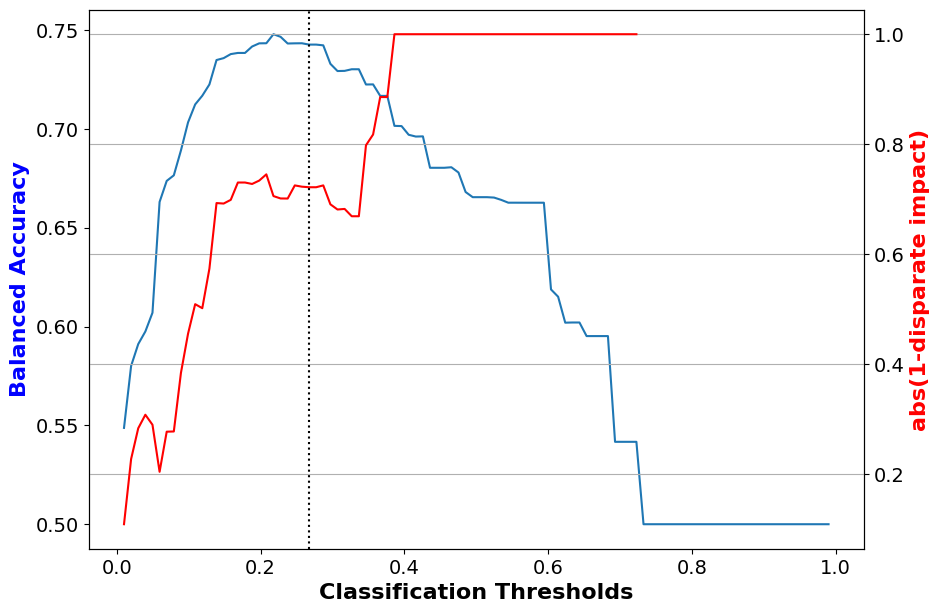

In [ ]:
%pip uninstall matplotlib
%pip install matplotlib==3.1.3

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_orig = np.abs(1.0-np.array(disp_imp_arr_orig))[best_ind]

```abs(1-disparate impact)``` must be close to zero for classifier predictions to be fair.

### Train classifier on transformed data and obtain predictions with its fairness metrics

In [ ]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = RandomForestClassifier(n_estimators=100, criterion='entropy')
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

dataset_transf_train_pred = dataset_transf_train.copy()
dataset_transf_train_pred.labels = y_train_pred

### Predictions and fairness metrics from transformed test set

In [ ]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)
X_test = scale_transf.transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [ ]:
display(Markdown("#### Predictions from transformed testing data"))

bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

display(Markdown("#### Testing set"))
display(Markdown("##### Transformed predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False
        
    metric_test_bef = compute_metrics(dataset_transf_test, dataset_transf_test_pred, 
                                       unprivileged_groups, privileged_groups, disp=disp)
    
    bal_acc_arr_transf.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_bef["Disparate impact"])

#### Predictions from transformed testing data

#### Testing set

##### Transformed predictions - No fairness constraints

 44%|████▍     | 44/100 [00:00<00:00, 107.26it/s]

Balanced accuracy = 0.7243
Statistical parity difference = -0.2385
Disparate impact = 0.5088
Average odds difference = -0.2183
Equal opportunity difference = -0.2221
Theil index = 0.1199


100%|██████████| 100/100 [00:00<00:00, 105.14it/s]


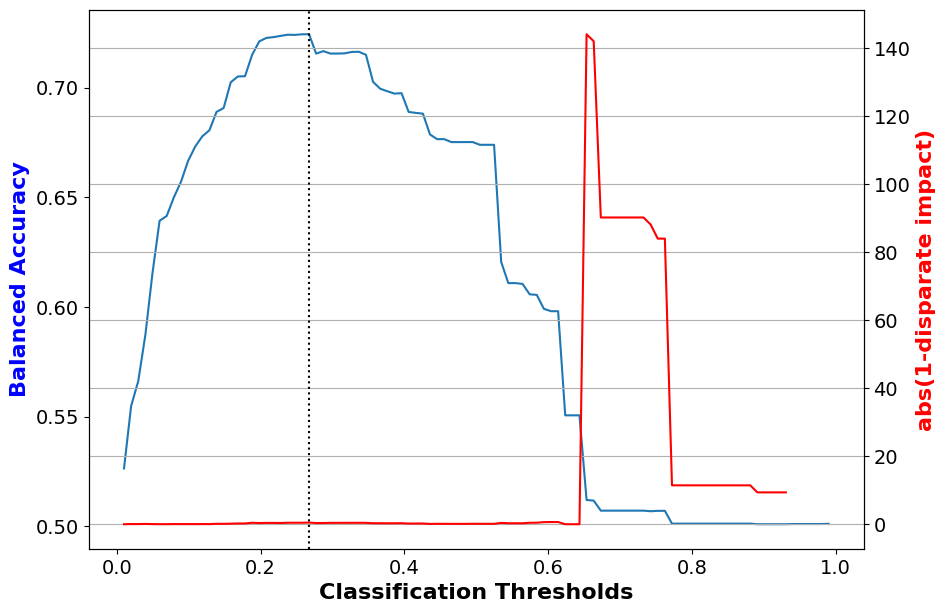

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_transf = np.abs(1.0-np.array(disp_imp_arr_transf))[best_ind]

```abs(1-disparate impact)``` must be close to zero for classifier predictions to be fair. This measure has improved using classifier trained using the transformed data compared to the original data.


In [ ]:
### testing
assert disp_imp_at_best_bal_acc_transf < disp_imp_at_best_bal_acc_orig

# Summary of Results
We show the optimal classification thresholds, and the fairness and accuracy metrics.

### Classification Thresholds

| Dataset |Classification threshold|
|-|-|
|Adult|0.2674|
|German|0.6732|
|Compas|0.5148|

### Fairness Metric: Disparate impact, Accuracy Metric: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|Race/Age (Acc-Bef)|Race/Age (Acc-Aft)|Race/Age (Fair-Bef)|Race/Age (Fair-Aft)|
|-|-|-|-|-|-|-|-|-|
|Adult (Test)|0.7417|0.7021|0.2774|0.7729|0.7417|0.7408|0.4423|0.7645|
|German (Test)|0.6524|0.5698|0.9948|1.0664|0.6524|0.6067|0.3824|0.8228|
|Compas (Test)|0.6774|0.6606|0.6631|0.8085|0.6774|0.6790|0.6600|0.8430|
